In [12]:
import seaborn as sns
import os
import sys
import numpy as np
import random

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiments.result_buckets import human_results
from experiments.bucket_analysis import BucketDatasetResult

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
## section 5 table 3

for dataset in ['snli', 'atomic', 'social', 'anli']:
    bucket_preds = human_results['roberta'][f'{dataset}-human']
    test_preds = human_results['roberta'][f'{dataset}-test']

    print(dataset)
    print('C:', bucket_preds.mean_unweighted_consistency)
    print('C_w:', bucket_preds.calculate_weighted_consistency(test_preds))
    print('POVE:', bucket_preds.law_of_total_variance_breakdown()['prop_explained'])
    print('POVE_w:', bucket_preds.calculate_weighted_proportion_explained(test_preds))
    print()

snli
C: 0.7052253968253969
C_w: 0.9064806546026608
POVE: 0.4938082810751717
POVE_w: 0.33477624667106926

atomic
C: 0.7478507936507937
C_w: 0.8616549681381606
POVE: 0.5186940972384994
POVE_w: 0.4083021609486061

social
C: 0.6592190476190476
C_w: 0.9087363234357935
POVE: 0.47714706628859094
POVE_w: 0.3302885539058762

anli
C: 0.6805238095238096
C_w: 0.8744013294599748
POVE: 0.38334927850754574
POVE_w: 0.2656007255507767



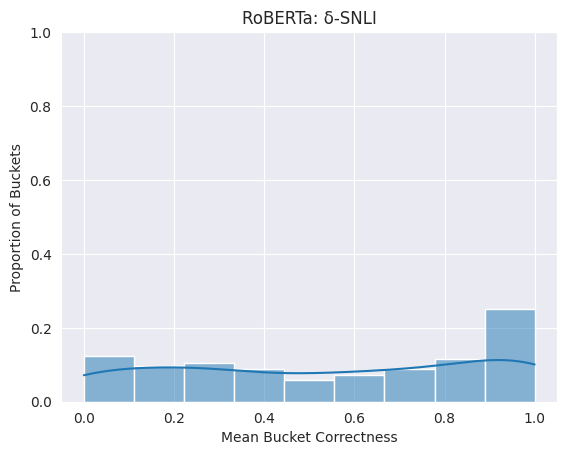

In [54]:
sns.set_style("darkgrid")

sns.histplot([b.bucket_correctness_mean for b in human_results['roberta']['snli-human'].buckets], kde=True, stat='proportion')
# Add a title and name the axes
ax = plt.gca()
# Set the title for the plot
ax.set_title("RoBERTa: δ-SNLI")
ax.set_xlabel("Mean Bucket Correctness")
ax.set_ylabel("Proportion of Buckets")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(0, 1)
plt.show()

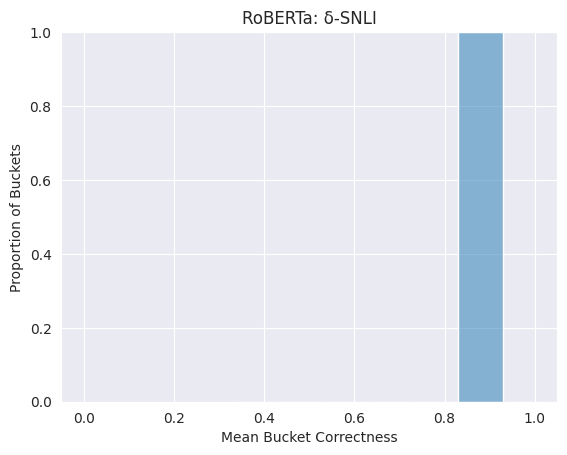

In [53]:
sns.histplot([0.83 for b in human_results['roberta']['snli-human'].buckets], kde=True, stat='proportion', bins=10)
ax = plt.gca()
# Set the title for the plot
ax.set_title("RoBERTa: δ-SNLI")
ax.set_xlabel("Mean Bucket Correctness")
ax.set_ylabel("Proportion of Buckets")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(0, 1)
plt.show()

bow
#### Agreement Consistency ####
Unweighted consistency: 0.7896619047619047
Weighted consistency: 0.775510453009061

#### Linguistic Variance ####
Proportion Variance Explained: 0.6420444614924627
Weighted Proportion Variance Explained: 0.9965897481788942

bilstm
#### Agreement Consistency ####
Unweighted consistency: 0.7037396825396826
Weighted consistency: 0.7300803424735418

#### Linguistic Variance ####
Proportion Variance Explained: 0.4561960103182316
Weighted Proportion Variance Explained: 0.4133455126510221

roberta
#### Agreement Consistency ####
Unweighted consistency: 0.7052253968253969
Weighted consistency: 0.9064806546026608

#### Linguistic Variance ####
Proportion Variance Explained: 0.4938082810751717
Weighted Proportion Variance Explained: 0.33477624667106926

deberta_v3
#### Agreement Consistency ####
Unweighted consistency: 0.8334777777777778
Weighted consistency: 0.8517536361379148

#### Linguistic Variance ####
Proportion Variance Explained: 0.5874315808473034
We

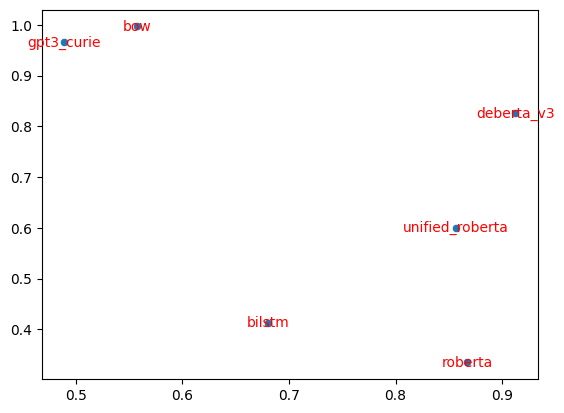

In [13]:
from simple_colors import *
import matplotlib.pyplot as plt
x = []
y = []
names = []

for model, results in human_results.items():
    analysis = results['snli-human']
    test_results = results['snli-test']
    
    print(green(model))
    variance_law = analysis.law_of_total_variance_breakdown()
    test_set_accuracy = test_results.accuracy
    # print('Total variance:', variance_law['total_var_y'])
    # print('Test set accuracy:', test_set_accuracy)
    # print('Paraphrase acc:', analysis.paraphrase_accuracy())
    # print('Variance of bernoulli with acc:', (analysis.paraphrase_accuracy() * (1-analysis.paraphrase_accuracy())))

    print("#### Agreement Consistency ####")
    print('Unweighted consistency:', analysis.mean_unweighted_consistency)
    print('Weighted consistency:', analysis.calculate_weighted_consistency(test_results))

    print("\n#### Linguistic Variance ####")
    print('Proportion Variance Explained:', variance_law['prop_explained'])
    print('Weighted Proportion Variance Explained:', analysis.calculate_weighted_proportion_explained(test_results))
    
    
    print()
    x.append(test_set_accuracy)
    y.append(analysis.calculate_weighted_proportion_explained(test_results))
    names.append(model)

sns.scatterplot(x=x, y=y)
for i in range(len(names)):
    plt.text(x[i], y[i], names[i], fontsize=10, ha='center', va='center', color='red')


In [ ]:
import plotly.express as px

# This plot shows that the there is positive correlation between how extreme the confidence is and discrete consistency.

model = human_results['roberta']['snli-human']

x = [b.original_example_prediction.confidence_deviation for b in model.buckets]
y = [b.bucket_discrete_agreement for b in model.buckets]

fig = px.scatter(x=x, y=y, labels={'x': 'deviation', 'y': 'discrete_agreement'}, trendline="ols")

fig.show()